In [1]:
using DIVAnd
using PyPlot
using NCDatasets
using Missings
using Interpolations
using Plots

if VERSION >= v"0.7"
    using Random
    using DelimitedFiles
    using Statistics
    using Printf
    using FileIO
else
    using Compat: @info, @warn, range, cat
end

include("../src/emodnet_bio_grid.jl");
pyplot()

┌ Info: Recompiling stale cache file /home/ctroupin/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


Plots.PyPlotBackend()

In [2]:
function read_benthos(filename::String)
    data,header = readdlm(fname,',',header = true)
    header = header[:]

    # "data","x","y","sta","g1","g2","g3"
    dataname = Vector{String}(data[:,findfirst(header .== "data")]);

    obslon = Vector{Float64}(data[:,findfirst(header .== "x")]);
    obslat = Vector{Float64}(data[:,findfirst(header .== "y")]);

    stationname = Vector{String}(data[:,findfirst(header .== "sta")]);

    g1 = Vector{Float64}(data[:,findfirst(header .== "g1")]);
    g2 = Vector{Float64}(data[:,findfirst(header .== "g2")]);
    g3 = Vector{Float64}(data[:,findfirst(header .== "g3")]);
    
    return obslon, obslat, g1, g2, g3
end

read_benthos (generic function with 1 method)

## Load and plot data

In [3]:
fname = joinpath(datadir, "Olivier-Benthos/tab.csv");
obslon, obslat, g1, g2, g3 = read_benthos(fname);
@info extrema(obslat)
@info extrema(obslon)

┌ Info: (41.3894, 72.579834)
└ @ Main In[3]:3
┌ Info: (-9.39937, 34.328014)
└ @ Main In[3]:4


In [4]:
fname = joinpath(datadir, "Olivier-Benthos/tabsr.csv");
obslon2, obslat2, _ , _ , _ = read_benthos(fname);
@info extrema(obslat2)
@info extrema(obslon2)

┌ Info: (36.8451, 72.579834)
└ @ Main In[4]:3
┌ Info: (-9.718917, 34.328014)
└ @ Main In[4]:4


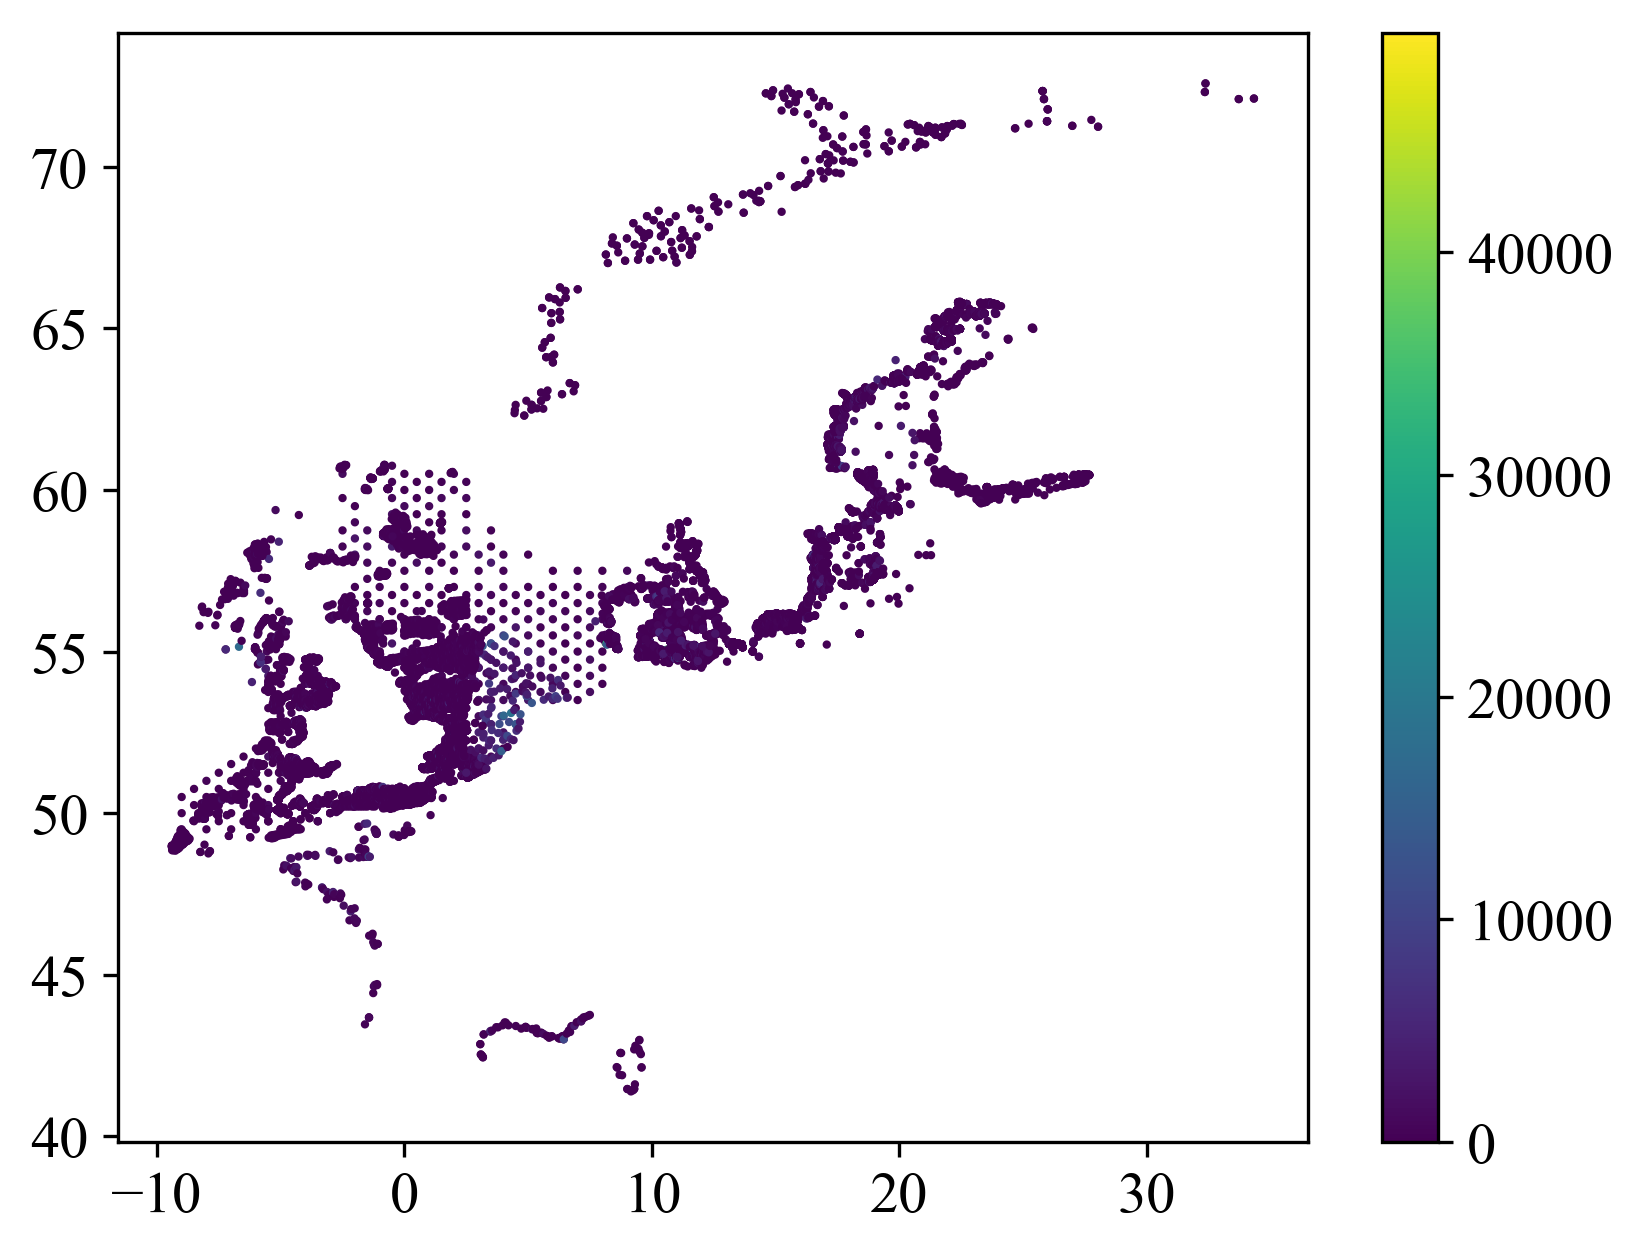

extrema(g1) = (0.0, 49860.0)


(0.0, 49860.0)

In [106]:
scat = PyPlot.scatter(obslon, obslat, s=1, c=g1)
# plot(obslon2, obslat2, "ko", markersize=0.2)
colorbar(scat)
@show extrema(g1)

### Histograms

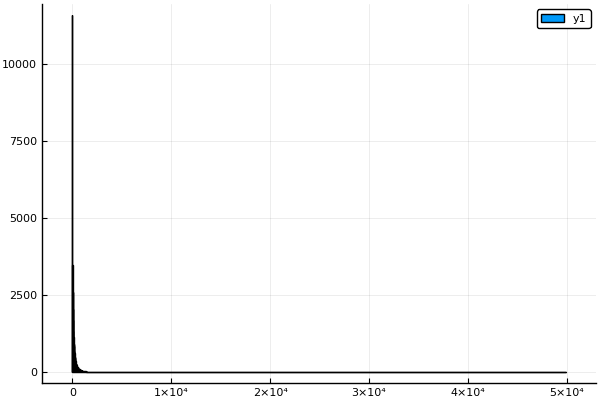

In [12]:
histogram(g1)

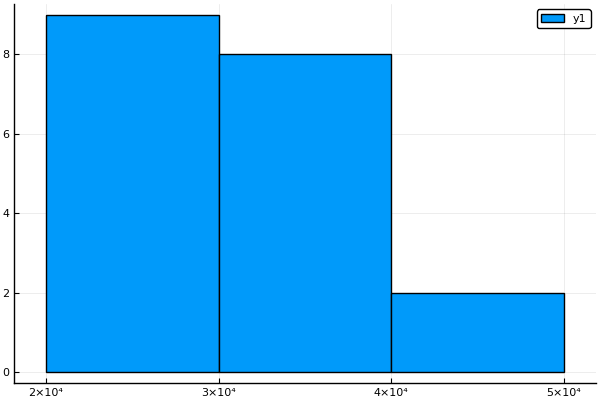

In [107]:
histogram(g1[g1 .> 20000])

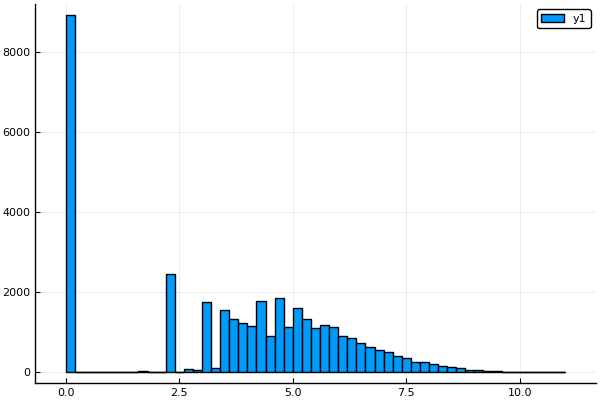

In [55]:
histogram(log.(g1.+1))

## Parameters

In [5]:
# Grid stored in emodnet_bio_grid.jl
xi,yi = DIVAnd.ndgrid(gridlonBenthos, gridlatBenthos);

In [6]:
# Reference field: different ways to compute it, comparison shown for information
# Choice is the mean of the log (... + 1)
fref0 = mean(g1)
fref1 = mean(log10.(g1 .+ 1))   # → the one that will be used
fref2 = log10(mean(g1) + 1)
fref3 = median(g1)
fref4 = median(log10.(g1 .+ 1))
fref5 = log10(median(g1) + 1)
fref6 = mean(g1[g1 .> 1000.])
fref0, fref1, fref2, fref3, fref4, fref5, fref6 # fref4 == fref5  😸

(360.9649838336674, 1.6069470526957537, 2.5586665593084046, 60.0, 1.7853298350107671, 1.7853298350107671, 3049.5356455402816)

In [7]:
# Mask
topodir = "/home/ctroupin/Projects/Diva-Workshops/notebooks/data/"
topofile = joinpath(topodir, "gebco_30sec_8.nc");

if isfile(topofile)
    bx, by, b = DIVAnd.load_bath(topofile,true,gridlonBenthos, gridlatBenthos);
    xmask, ymask, mmask = DIVAnd.load_mask(topofile,true,gridlonBenthos, gridlatBenthos,[0]);
else
    @error "Bathymetry file doesn't exist"
end
mmask = mmask[:,:,1]
@info size(mmask)

┌ Info: (451, 371)
└ @ Main In[7]:12


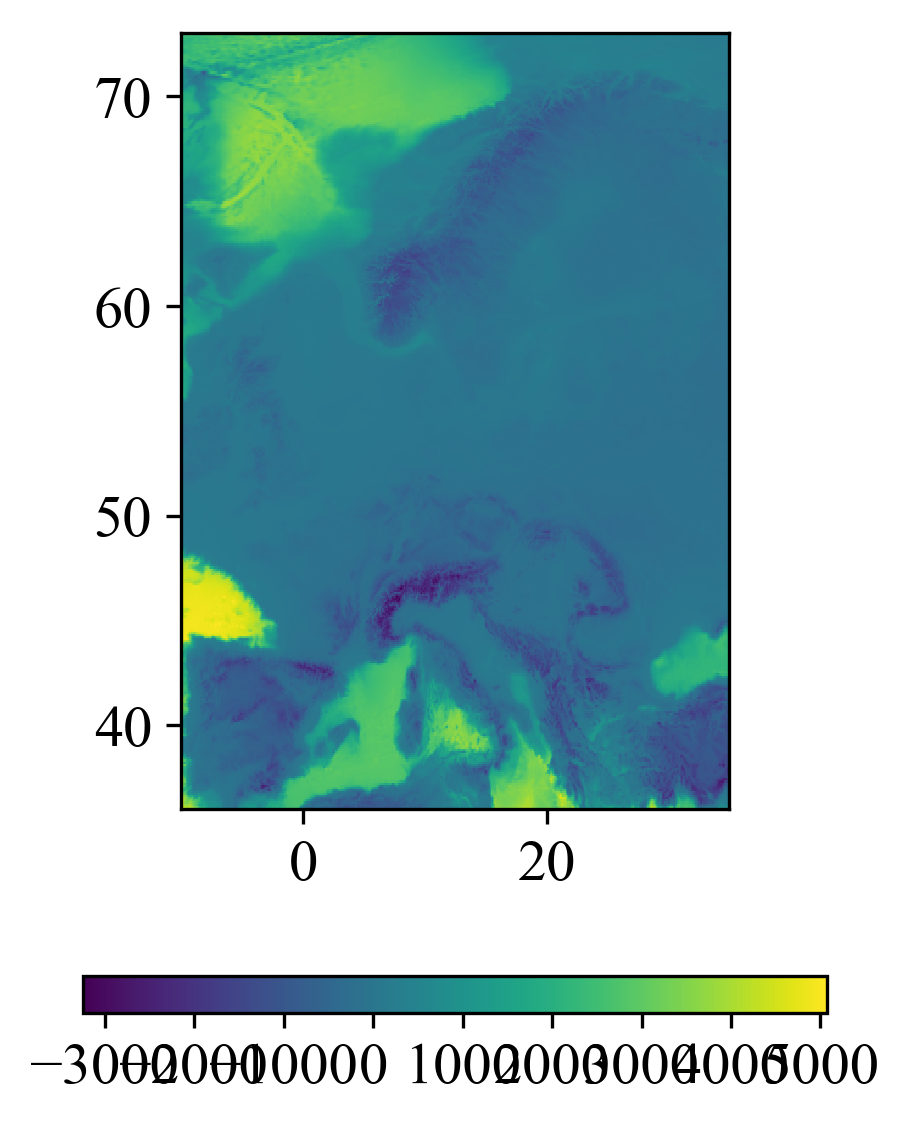

In [8]:
pcolor(bx, by, permutedims(b, [2, 1])); 
colorbar(orientation="horizontal", shrink=0.5)
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

In [9]:
# Metrics
pm = ones(size(xi)) / (xi[2,1]-xi[1,1]);
pn = ones(size(xi)) / (yi[1,2]-yi[1,1]);

In [10]:
# Parameter choice: sensitivity analysis
# correlation length
len = 3.;
# obs. error variance normalized by the background error variance
epsilon2 = 2.;

# Transformed fields
g1log = log.(g1.+1);
g2log = log.(g2.+1);
g3log = log.(g3.+1);

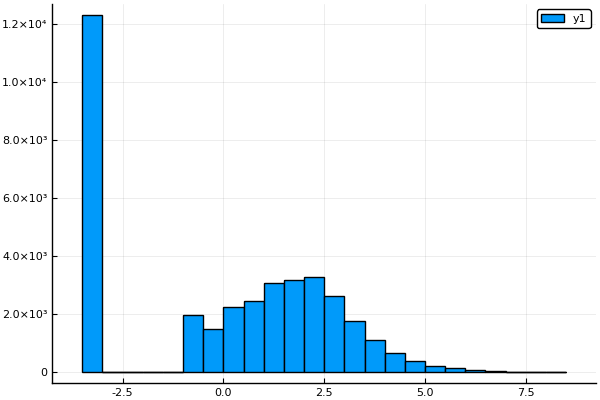

In [41]:
histogram(g3log .- mean(g3log))

In [36]:
## Estimation of the correlation length
distbin = 0:.5:7.5;
mincount = 100;
for distbin in [0:.125:7.5, 0:1:7.5, 0:.5:7.5, 0:.5:10]
#for mincount in [10,20,50,70,100,200]
    var0,lenHori,distx,covar,fitcovar = fit_isotropic((obslon,obslat),g3log .- mean(g3log),distbin,mincount);
    @show lenHori
end
# does not exhibit too sensitibility to the parameters mincount and distbin
# g2 leads to a longer correlation length and more variability according to distbin

lenHori = 0.44605415841584156
lenHori = 4.0544113861386135
lenHori = 2.0702149504950493
lenHori = 1.6201703960396039


In [34]:
?fit_isotropic

search: fit_isotropic



```
var0,len,distx,covar,fitcovar = fit_isotropic(x,v,distbin,mincount;
                           alpha = DIVAnd.alpha_default(length(x)),
                           minlen = 0.,
                           maxlen = 10.,
                           tolrel = 1e-4,
                           maxpoints = 10000,
                           nmean = 100,
                           distfun = (xi,xj) -> sqrt(sum(abs2,xi-xj))),
                           progress = (iter,var,len,fitness) -> nothing
                       )
```

Determines the optimal correlation length `len` and variance (for a separation distance approaching zero) `var0` of a cloud of data points with value `v` and coordiantes `x` (tuple of vectors with the coordinates).

The function can find the solution corresponding to a local minimum which is not necessarily the global minimum.

See also `empiriccovar` for future information about the output parameters.

Optional input parameters:

  * `alpha`: if one correlation length is forced to zero during the anaylsis the values of alpha sould be set using the effective dimension. For example, if a 2D-analysis is simulated by forcing the vertical correlation length to zero, then alpha should be set to `[1,2,1]`, otherwise alpha will be `[1,3,3,1]` (for any proper 3D analysis).
  * `len`: initial value for the correlation length.
  * `minlen`, `maxlen`: minimum and maximum values for the correlation length.
  * `tolrel`: relative tolerance for the optimizer.
  * `maxpoints`: maximum number of data points considered.
  * `nmean`: the number of times an empirical covariance is estimated.  The average covariance is used for the fitting.
  * `distfun`: function to compute the distance between point `xi` (vector) and  `xj`. Per default `distfun` is the Euclidian distance: `(xi,xj) -> sqrt(sum(abs2,xi-xj)))`.
  * `progress`: call-back function to show the progress of the optimization with the input parameters `iter`, `var`, `len` and `fitness` (all scalars).

The length-scale parameters and the variance have the corresponding units from the `x` and `v`. It is therefore often necessary to provide reasonable values for these default parameters.

The algorithm used to estimate the correlation-length and variance is based on randomly choosen points. Therefore the result can be different if the function is invoked repeately. If `nmean` is increased, then these statistical fluctuations should decrease (for a not too large value of `mincount`, i.e. about 100 for most cases).

If the lower bound `minlen` is too small, then you might get the following error:

```
AmosException with id 4: input argument magnitude too large, complete loss of accuracy by argument reduction.
```

In these case, increase `minlen`.


In [30]:
lenHori = 0.8630954455445544;

In [14]:
# decrease data weights for very close points
rdiag=1.0./DIVAnd.weight_RtimesOne((obslon,obslat),(0.03,0.03))
@show maximum(rdiag),mean(rdiag)

(maximum(rdiag), mean(rdiag)) = (439.41430043634114, 33.64254883518046)


(439.41430043634114, 33.64254883518046)

## Estimating the signal to noise ratio

In [31]:
epsilon2 = 0.02;
bestfactorl,bestfactore, cvval,cvvalues, x2Ddata,y2Ddata,cvinter,xi2D,yi2D = 
DIVAnd_cv(mmask[:,:,1],(pm,pn),(xi,yi),(obslon,obslat),g2log .- mean(g2log),lenHori,epsilon2*rdiag,2,3);
@show bestfactorl, bestfactore

(bestfactorl, bestfactore) = (0.15235515132193408, 0.4677351412871982)


(0.15235515132193408, 0.4677351412871982)

In [32]:
?DIVAnd_cv

search: DIVAnd_cv DIVAnd_cvestimator DIVAnd_GCVKii DIVAnd_GCVKiiobs



```
bestfactorl,bestfactore, cvval,cvvalues, x2Ddata,y2Ddata,cvinter,xi2D,yi2D = DIVAnd_cv(mask,pmn,xi,x,f,len,epsilon2,nl,ne,method;...);
```

# Input

Same as for `DIVAndrun` with three more parameters `nl`,`ne` and `method`

  * `mask`: binary mask delimiting the domain. true is inside and false outside. For oceanographic application, this is the land-sea mask.
  * `pmn`: scale factor of the grid. pmn is a tuple with n elements. Every      element represents the scale factor of the corresponding dimension. Its      inverse is the local resolution of the grid in a particular dimension.
  * `xi`: tuple with n elements. Every element represents a coordinate of the final grid on which the observations are interpolated
  * `x`: tuple with n elements. Every element represents a coordinate of the observations
  * `f`: value of the observations *minus* the background estimate (m-by-1 array).   (see note)
  * `len`: correlation length
  * `epsilon2`: error variance of the observations (normalized by the error variance of the background field). `epsilon2` can be a scalar (all observations have the same error variance and their errors are decorrelated), a vector (all observations can have a difference error variance and their errors are decorrelated) or a matrix (all observations can have a difference error variance and their errors can be correlated). If `epsilon2` is a scalar, it is thus the *inverse of the signal-to-noise ratio*.
  * `nl`: number of testing points around the current value of L. `1` means one additional point on both sides of the current L. `0` is allowed and means the parameter is not optimised.
  * `ne`: number of testing points around the current value of epsilon2. `0` is allowed as for `nl`
  * `method`: cross validation estimator method 1: full CV 2: sampled CV 3: GCV 0: automatic choice between the three possible ones, default value
  * Optional input arguments specified via keyword arguments are the same as for `DIVAnd`

# Output:

  * `bestfactorl`: best estimate of the multiplication factor to apply to len
  * `bestfactore`: best estimate of the multiplication factor to apply to epsilon2
  * `cvvales` : the cross validation values calculated
  * `factors` : the tested multiplication factors
  * `cvinter` : interpolated cv values for final optimisation
  * `X2Data, Y2Data` : coordinates of sampled cross validation in `L,epsilon2` space . Normally only used for debugging or plotting
  * `Xi2D, Yi2D` : coordinates of interpolated estimator . Normally only used for debugging or plotting

The output `bestfactorl` and `bestfactore` represent multiplication factors which should be applied to `L` and `epsilon2`.

The `len` and `epsilon2` provided should be close the real one as the tests will be performed around.


In [38]:
# Perform analysis using the selected reference field
@time fi1,s = DIVAnd.DIVAndrun(mmask[:,:,1],(pm,pn),(xi,yi),
    (obslon,obslat), g1log .- mean(g1log),len,epsilon2,alphabc=2);

@time fi2,s = DIVAnd.DIVAndrun(mmask[:,:,1],(pm,pn),(xi,yi),
    (obslon,obslat), g2log .- mean(g2log),len,epsilon2,alphabc=2);

@time fi3,s = DIVAnd.DIVAndrun(mmask[:,:,1],(pm,pn),(xi,yi),
    (obslon,obslat), g3log .- mean(g3log),len,epsilon2,alphabc=2);

  2.654011 seconds (4.91 M allocations: 1.572 GiB, 24.42% gc time)
  1.744536 seconds (2.30 M allocations: 1.450 GiB, 40.48% gc time)
  1.594832 seconds (2.30 M allocations: 1.450 GiB, 41.64% gc time)


### Error calculation

In [39]:
cpme = DIVAnd_cpme(mmask[:,:,1],(pm,pn),(xi,yi),(obslon,obslat), 
    g1log .- mean(g1log),len,epsilon2,alphabc=2);

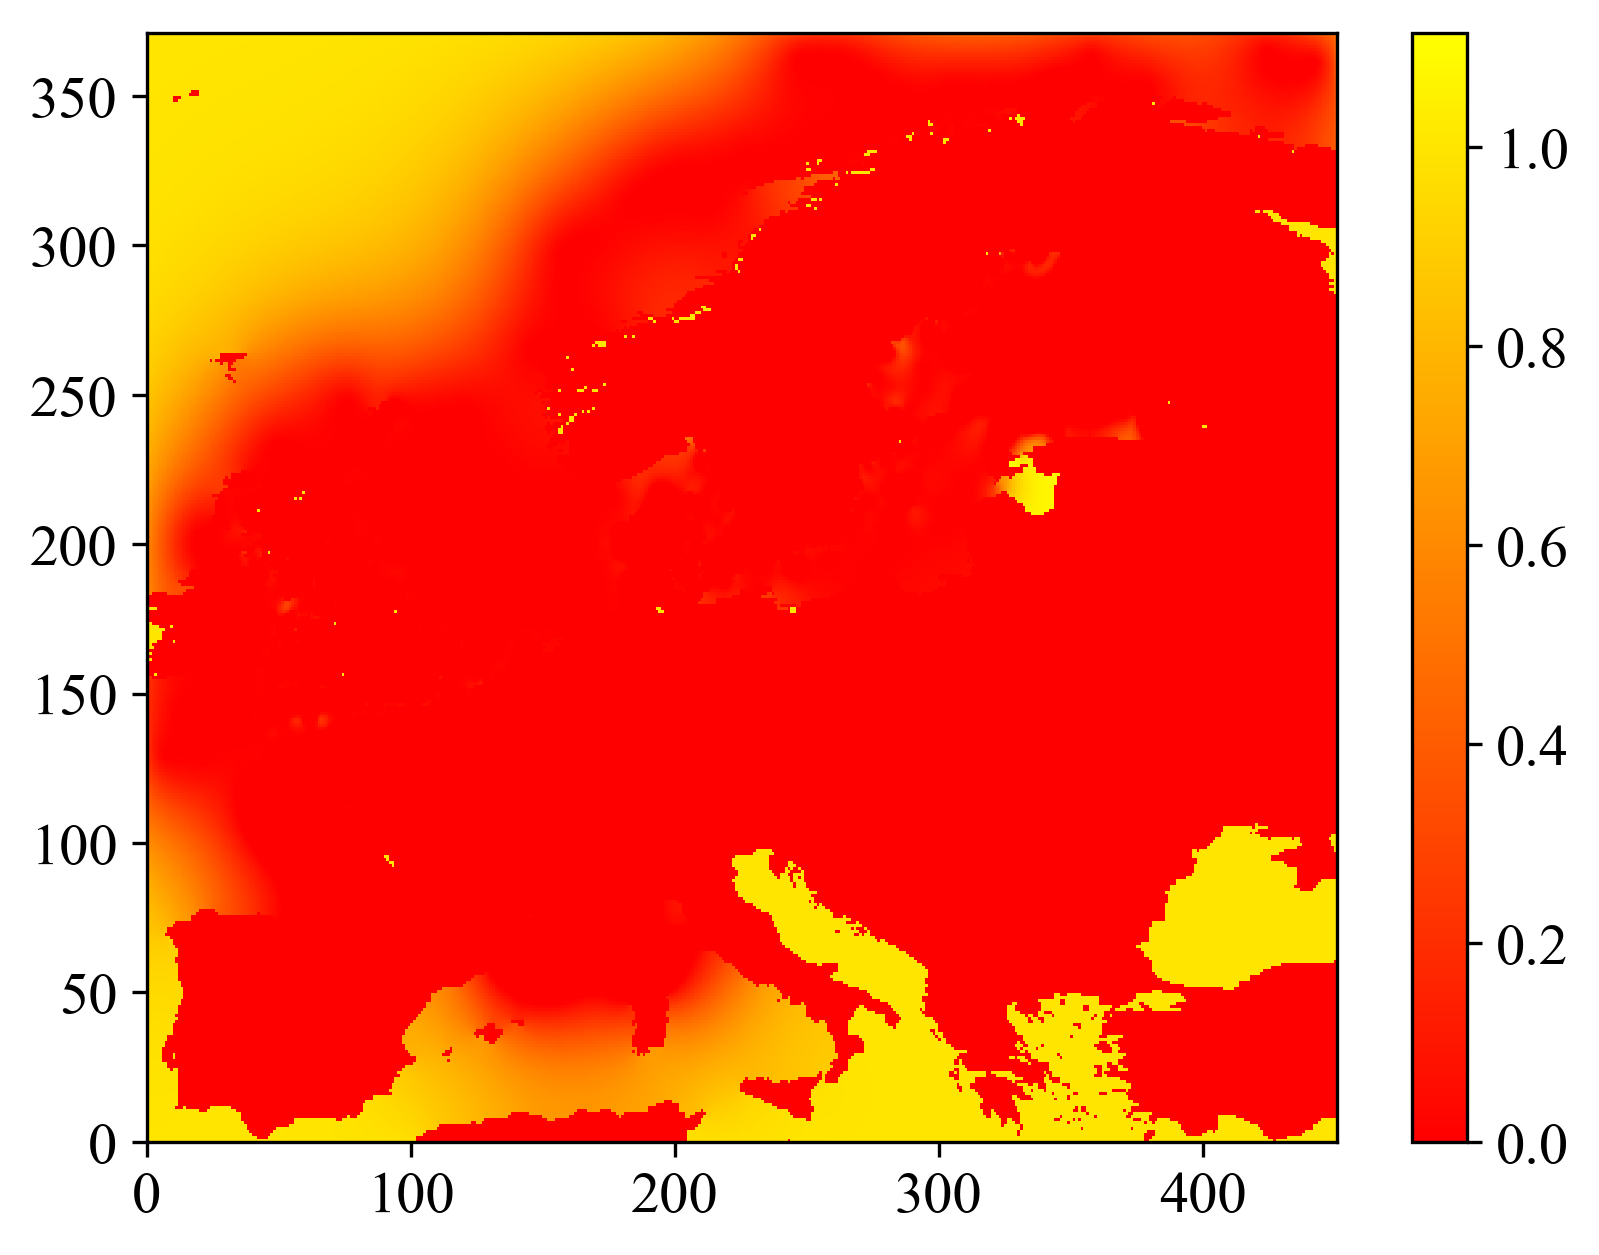

PyObject <matplotlib.colorbar.Colorbar object at 0x7ff38100d8d0>

In [49]:
cpme[isnan.(cpme)] .= 0.0
pcolormesh(permutedims(cpme, [2,1]), cmap=PyPlot.cm[:autumn]);
colorbar()

## More tests

In [116]:
function make_plot_grid(field1, field2, field3, fieldtotal; vmin=0, vmax=10.)
    figure()
    subplot(2,2,1)
    title("Resistant")
    pcolormesh(gridlonBenthos, gridlatBenthos, permutedims(field1, [2,1]), vmin=vmin, vmax=vmax)
    #PyPlot.scatter(obslon, obslat, s=0.5, c=g1log, vmin=0, vmax=10.)
    colorbar()
    subplot(2,2,2)
    title("Resilient")
    pcolormesh(gridlonBenthos, gridlatBenthos, permutedims(field2, [2,1]), vmin=vmin, vmax=vmax)
    #PyPlot.scatter(obslon, obslat, s=0.5, c=g2log, vmin=0, vmax=10.)
    colorbar()
    subplot(2,2,3)
    title("Vulnerable")
    pcolormesh(gridlonBenthos, gridlatBenthos, permutedims(field3, [2,1]), vmin=vmin, vmax=vmax)
    #PyPlot.scatter(obslon, obslat, s=0.5, c=g3log, vmin=0, vmax=10.)
    colorbar()
    subplot(2,2,4)
    pcolormesh(gridlonBenthos, gridlatBenthos, permutedims(fieldtotal, [2,1]), vmin=0.)
    colorbar()
end

make_plot_grid (generic function with 3 methods)

### Interpolated fields without transformation

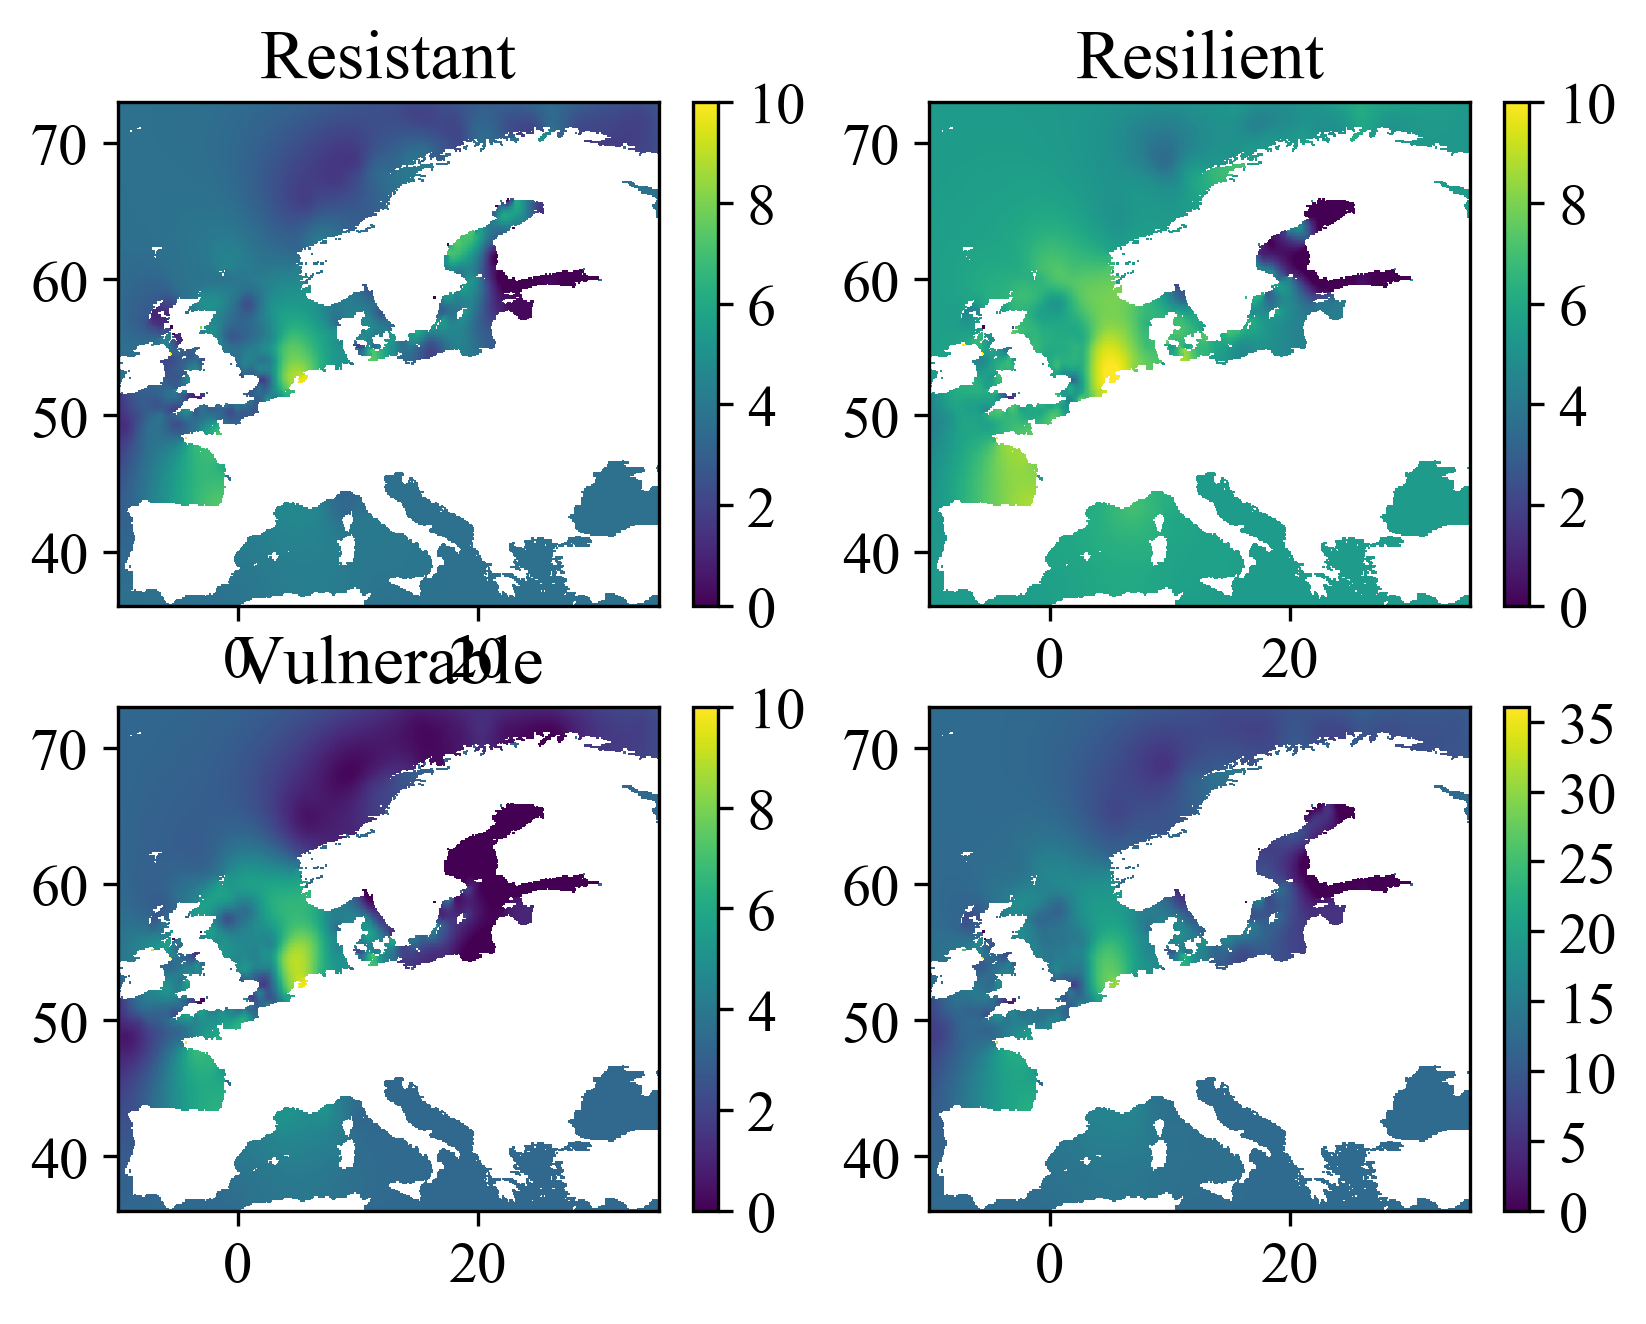

PyObject <matplotlib.colorbar.Colorbar object at 0x7f83a13dc668>

In [111]:
make_plot_grid(fi1.+ mean(g1log), fi2.+ mean(g2log), fi3.+ mean(g3log), 
    fi1 + fi2 + fi3 .+ mean(g1log) .+ mean(g2log) .+ mean(g3log))

### Interpolated after transformation (exp)

In [50]:
# Tranform back and relative fields
fi1ori = exp.(fi1 .+ mean(g1log)) .- 1;
fi2ori = exp.(fi2 .+ mean(g2log)) .- 1;
fi3ori = exp.(fi3 .+ mean(g3log)) .- 1;
fi1ori[fi1ori.<0] .= 0.
fi2ori[fi2ori.<0] .= 0.
fi3ori[fi3ori.<0] .= 0.
totalfield = fi1ori + fi2ori + fi3ori;
fi1rel, fi2rel, fi3rel = fi1ori./totalfield, fi2ori./totalfield, fi3ori./totalfield;

In [51]:
@show extrema(filter(!isnan, fi1ori))
@show extrema(g1)

extrema(filter(!isnan, fi1ori)) = (0.0, 6.584844183840566e10)
extrema(g1) = (0.0, 49860.0)


(0.0, 49860.0)

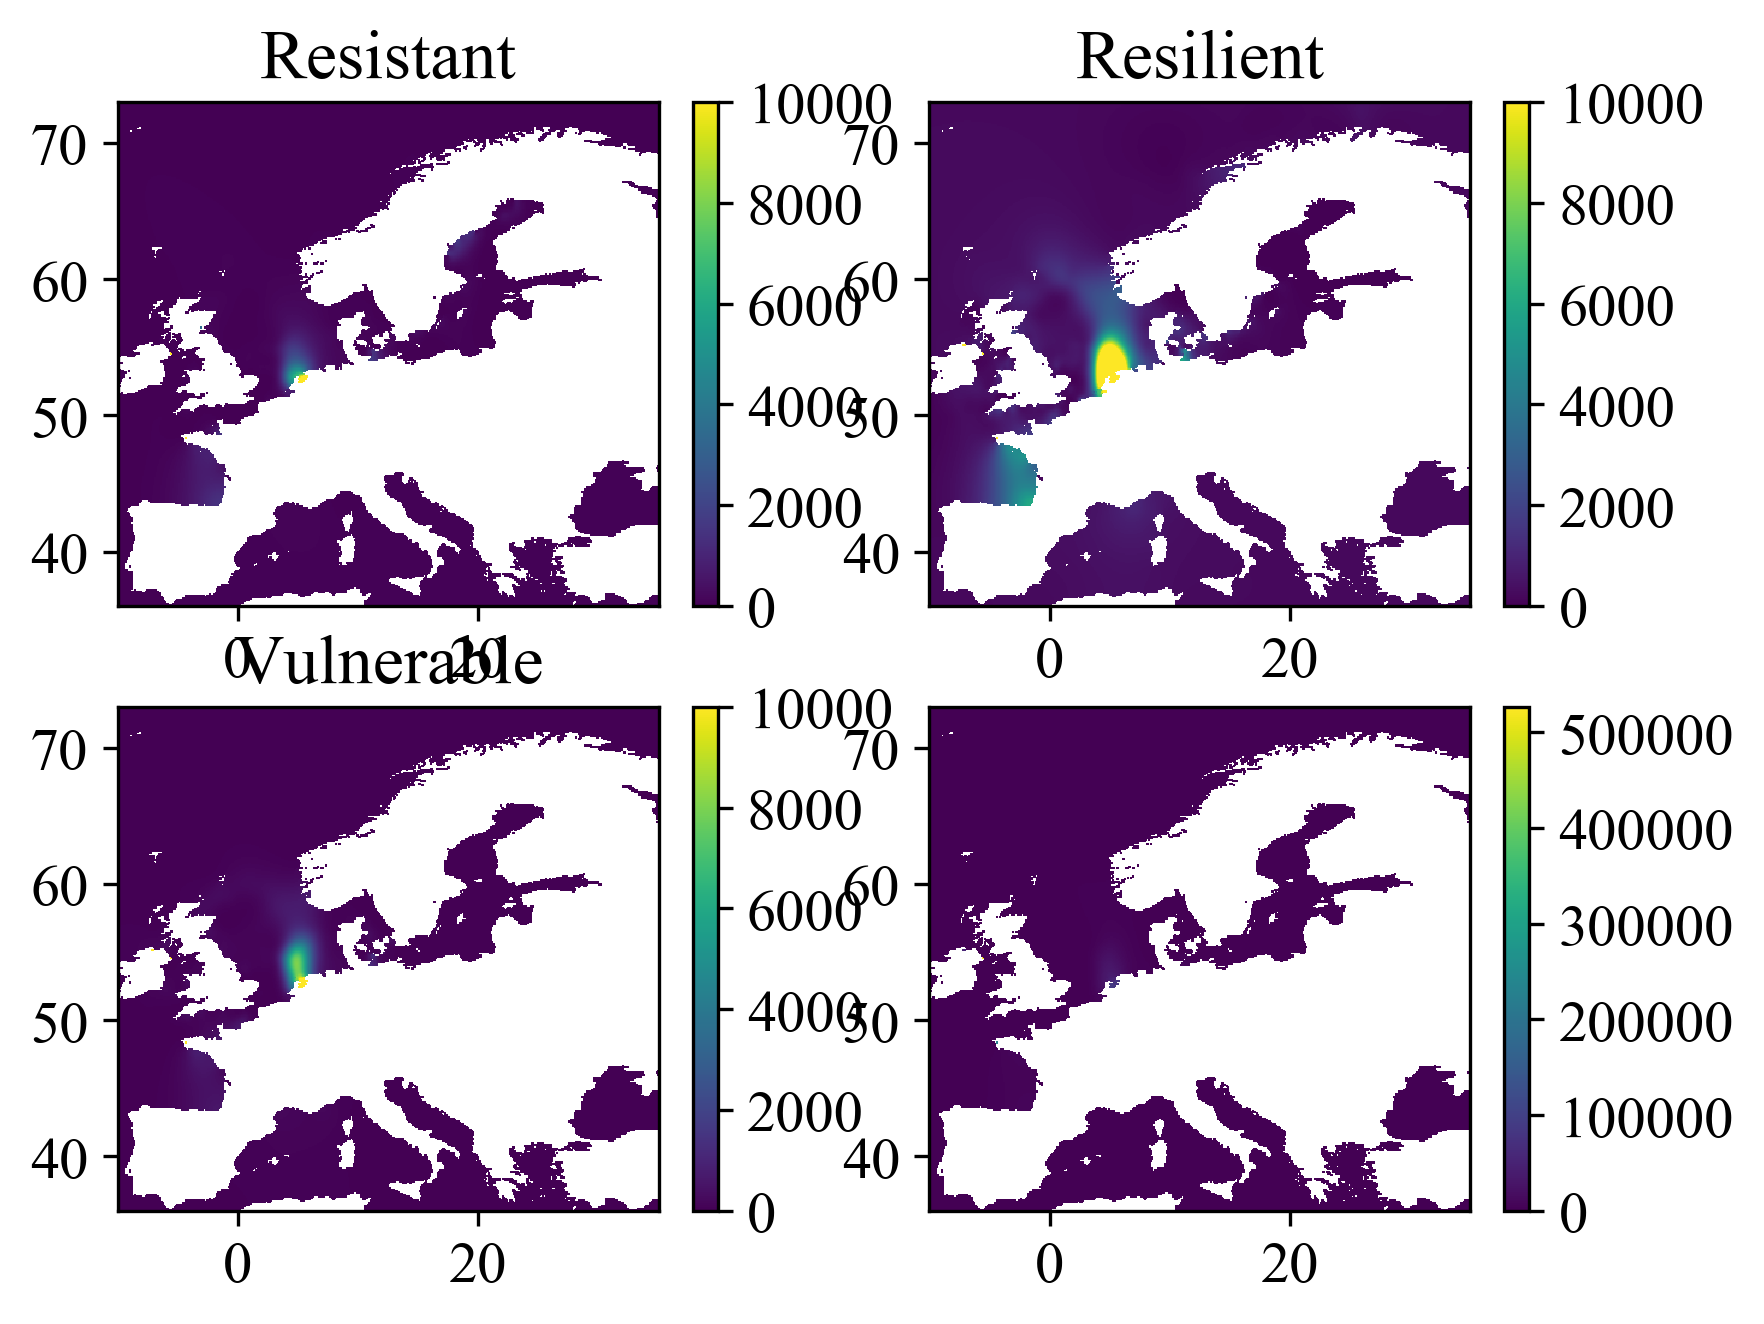

PyObject <matplotlib.colorbar.Colorbar object at 0x7f83a068ce10>

In [150]:
make_plot_grid(fi1ori, fi2ori, fi3ori, totalfield, vmin=0, vmax=10000.)

### Relative fields

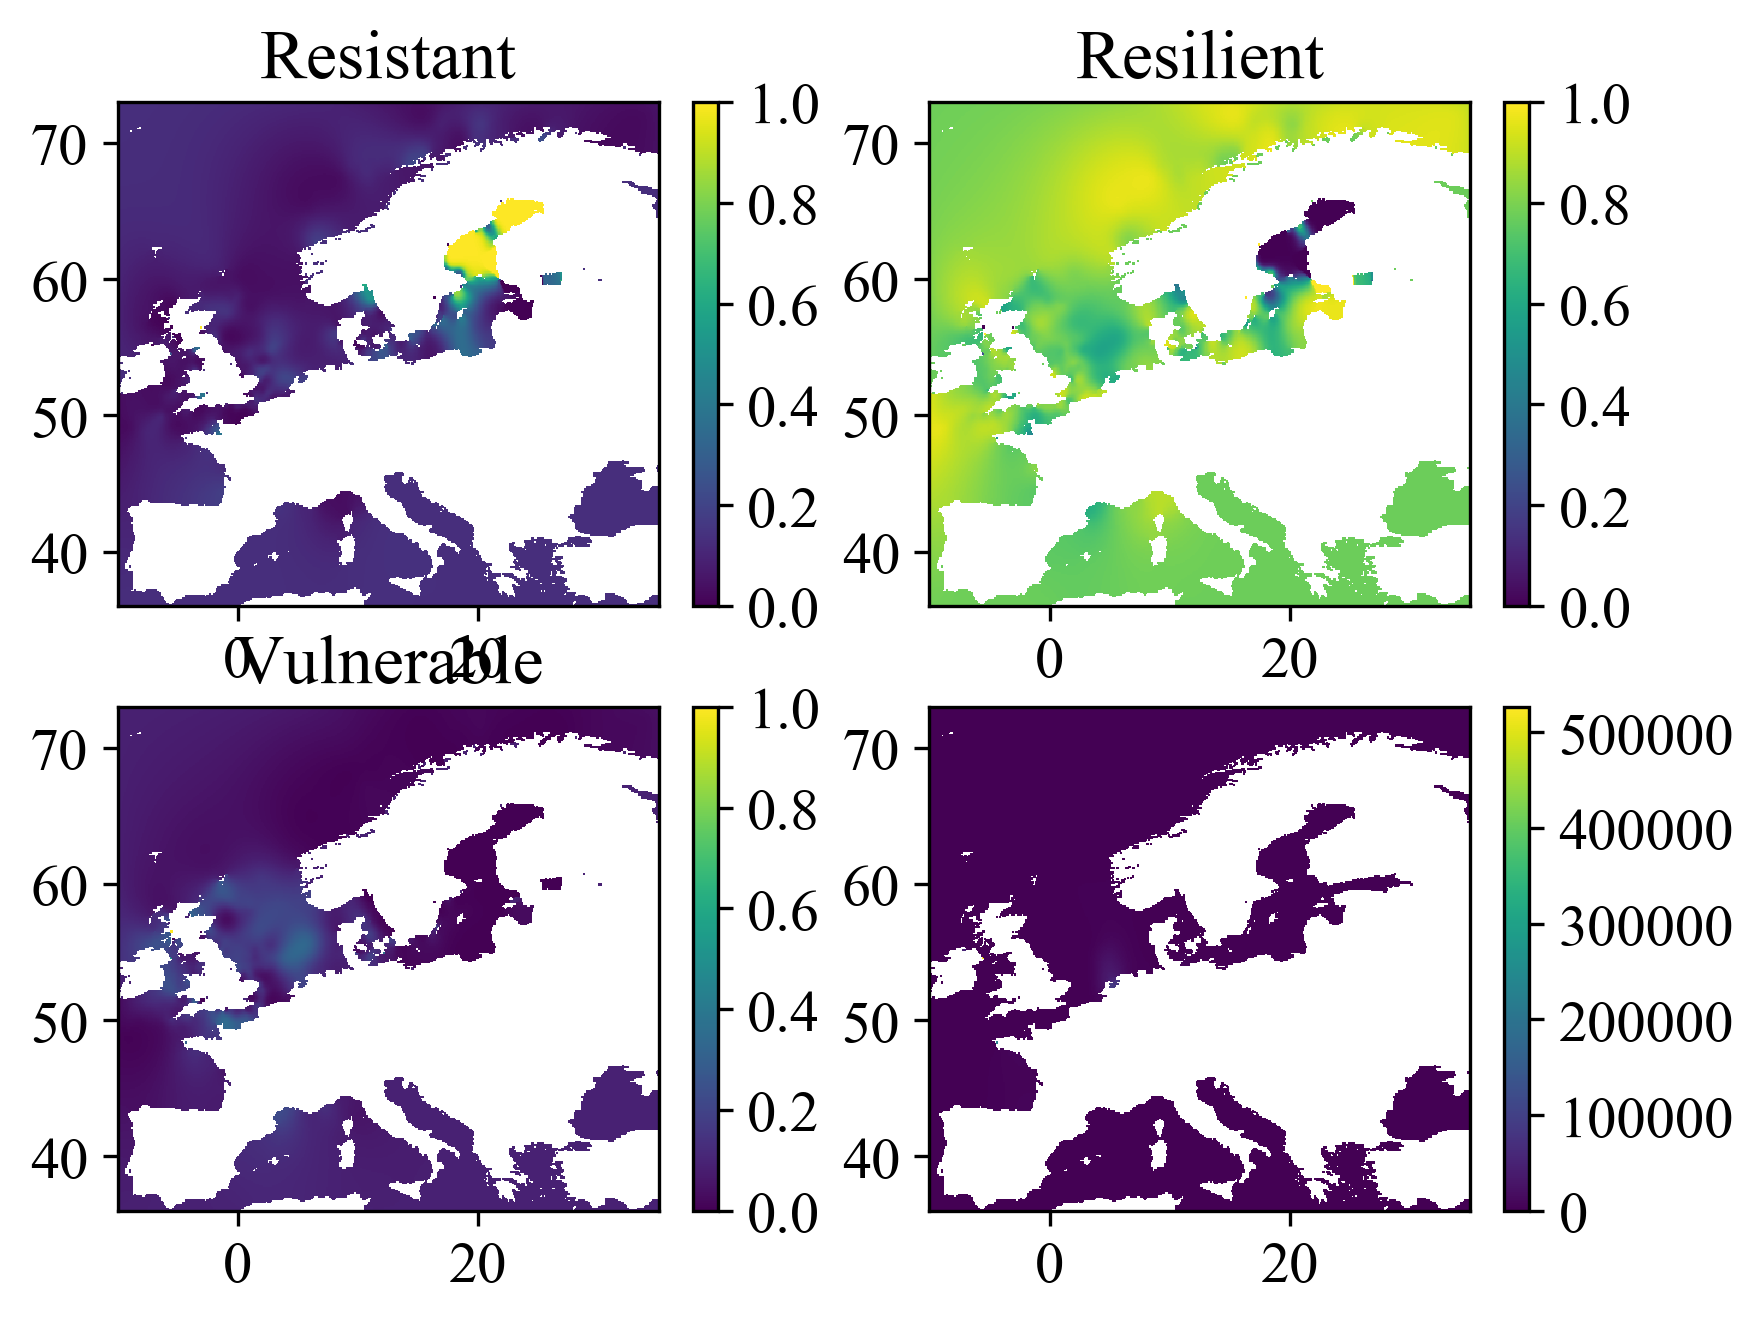

In [158]:
make_plot_grid(fi1rel, fi2rel, fi3rel, totalfield, vmin=0, vmax=1.)
PyPlot.savefig("benthos_interp.png", dpi=300)

In [54]:
DIVAnd.save("test1.nc", (gridlonBenthos, gridlatBenthos), fi1rel, "g1rel");
DIVAnd.save("test1.nc", (gridlonBenthos, gridlatBenthos), fi2rel, "g2rel");

In [55]:
?DIVAnd.save

```
save(filename,xyi,fi,varname;
                      ncvarattrib = Dict(), ncglobalattrib = Dict(), ...)
```

Save the result of the analysis in a NetCDF file .

# Input arguments

  * `filename`: the name of the NetCDF file
  * `xyi`: tuple with n vectors. Every element in this tuple represents a coordinate of the final grid on which the observations are interpolated
  * `fi`: the analysed field
  * `varname`: the name of the NetCDF variable

# Optional arguments:

  * `ncglobalattrib`: a dictionary with the global attributes
  * `ncvarattrib`: a dictionary with the variable attributes
  * `relerr`: relative error


In [20]:
fishdatadir = "/home/ctroupin/tmp/Emodnet-Bio/Olivier-Fish/"
datafileS = joinpath(fishdatadir, "tabFishSpatial.csv")
datafileT = joinpath(fishdatadir, "tabFishTemporal.csv")

"/home/ctroupin/tmp/Emodnet-Bio/Olivier-Fish/tabFishTemporal.csv"

In [31]:
function read_fish(filename::String)
    data,header = readdlm(filename,',',header = true)
    header = header[:]
    if "sta" in header
        @info "Spatial data file"
        stationname = Vector{String}(data[:,findfirst(header .== "sta")]);
        obsyear = Array{Int32,1}(undef,1)
        #elseif "year" in header
    else
        @info "Temporal data file"
        stationname = Vector{String}(data[:,findfirst(header .== "samp")]);
        obsyear = Vector{Int32}(data[:,findfirst(header .== "year")]);
    end;

    # "x","y","sta","g1","g2","g3","g4"
    # "year","x","y","samp","g1","g2","g3","g4"

    # dataname = Vector{String}(data[:,findfirst(header .== "data")]);

    obslon = Vector{Float64}(data[:,findfirst(header .== "x")]);
    obslat = Vector{Float64}(data[:,findfirst(header .== "y")]);

    g1 = Vector{Float64}(data[:,findfirst(header .== "g1")]);
    g2 = Vector{Float64}(data[:,findfirst(header .== "g2")]);
    g3 = Vector{Float64}(data[:,findfirst(header .== "g3")]);
    g4 = Vector{Float64}(data[:,findfirst(header .== "g3")]);
    
    return obslon, obslat, obsyear, g1, g2, g3, g4
end

read_fish (generic function with 1 method)

In [41]:
@time obslonT, obslatT, obsyearT, g1T, g2T, g3T, g4T = read_fish(datafileT);
@time obslonS, obslatS, obsyearS, g1S, g2S, g3S, g4S = read_fish(datafileS);

┌ Info: Temporal data file
└ @ Main In[31]:10


  1.098765 seconds (10.37 M allocations: 329.718 MiB, 44.95% gc time)


┌ Info: Spatial data file
└ @ Main In[31]:5


  0.120697 seconds (1.50 M allocations: 48.614 MiB, 29.69% gc time)


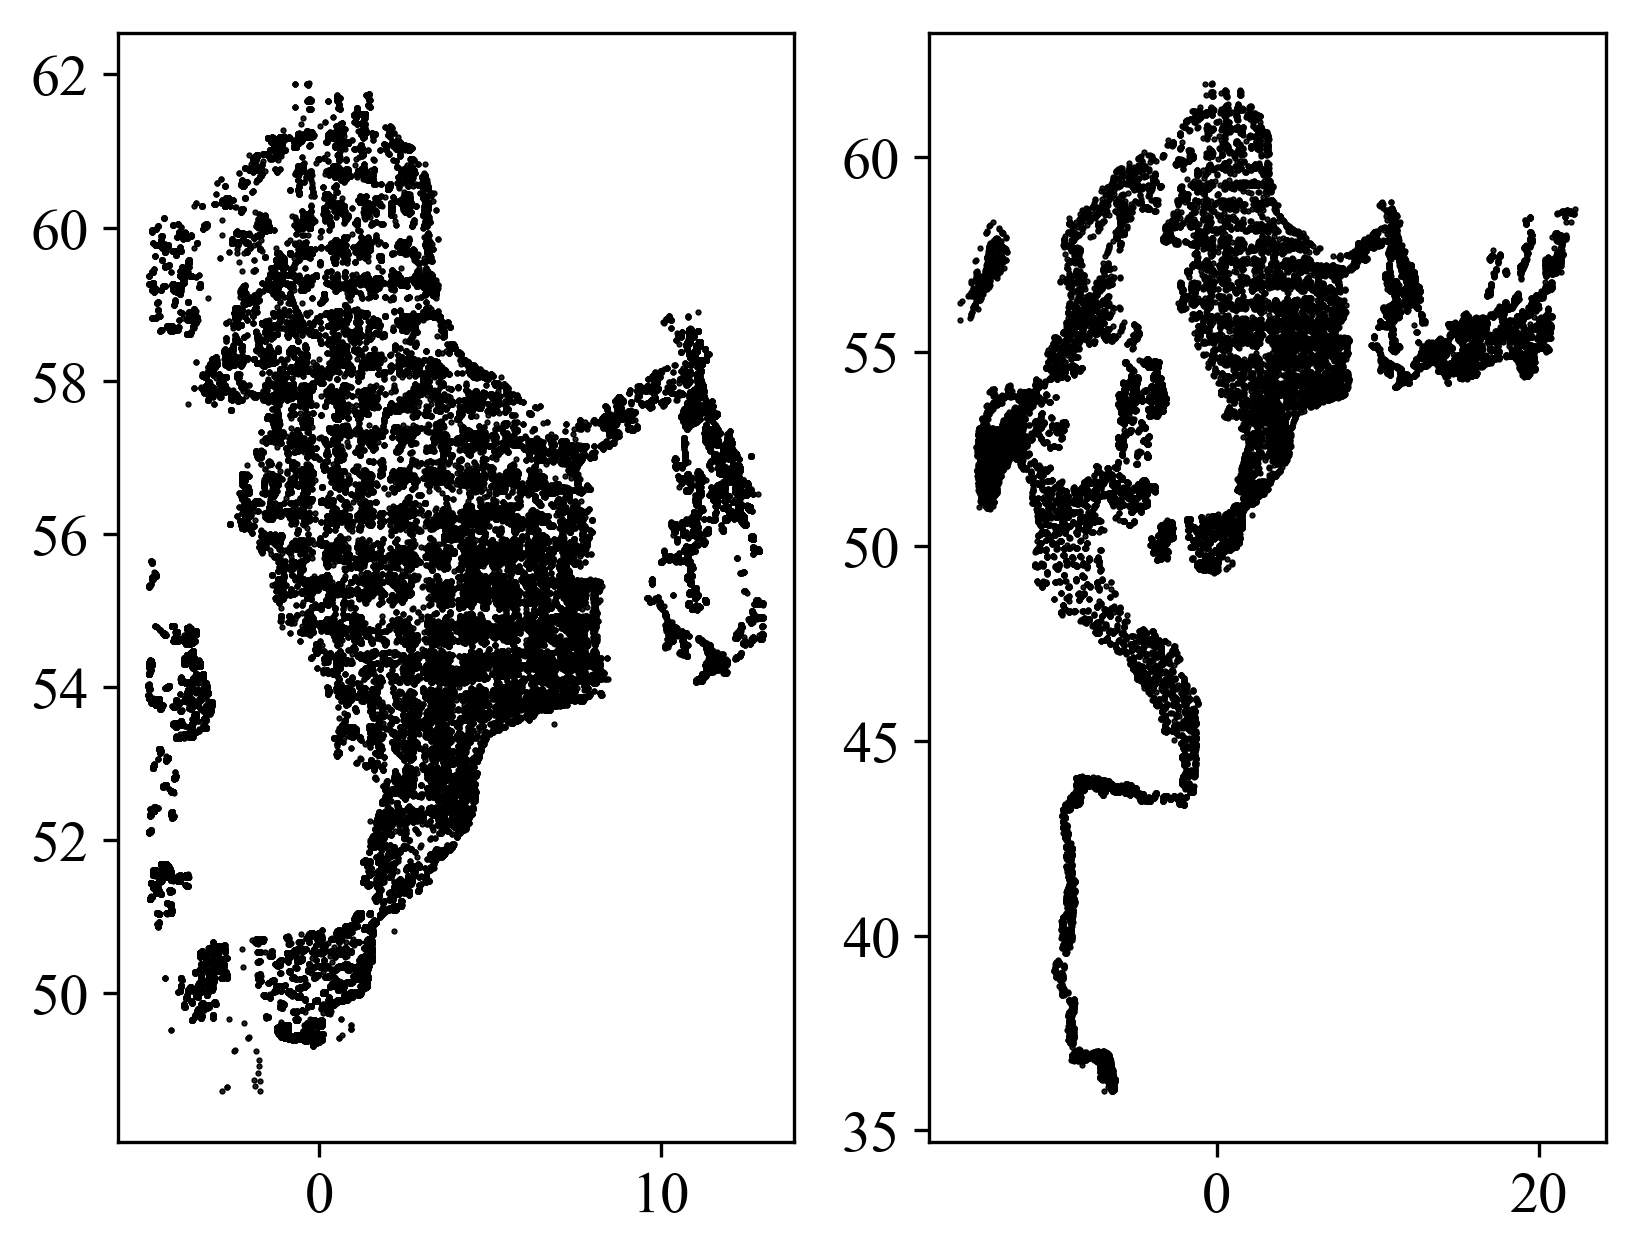

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbf7948c748>

In [48]:
figure()
subplot(1,2,1)
PyPlot.plot(obslonT, obslatT, "ko", markersize=.5)
subplot(1,2,2)
PyPlot.plot(obslonS, obslatS, "ko", markersize=.5)

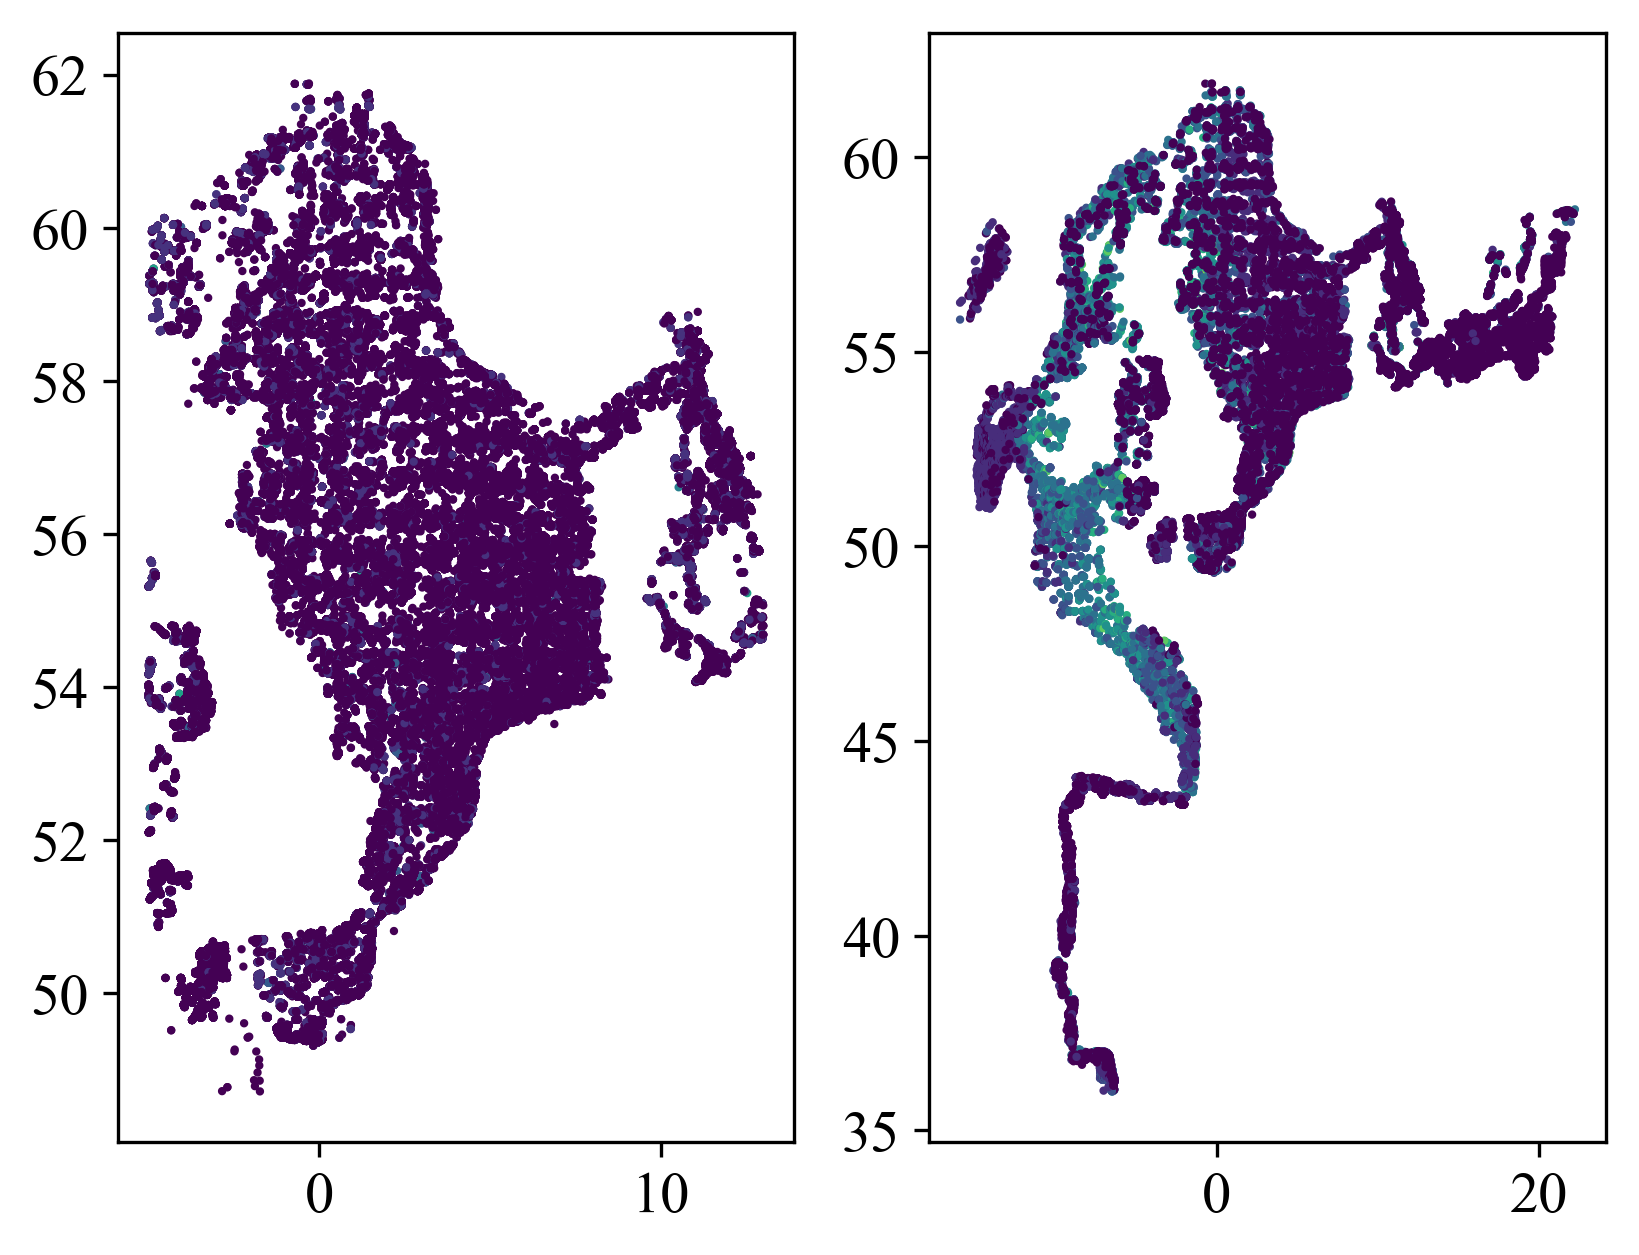

PyObject <matplotlib.collections.PathCollection object at 0x7fbf7ca1e710>

In [42]:
figure()
subplot(1,2,1)
PyPlot.scatter(obslonT, obslatT, s=1, c=g1T)
subplot(1,2,2)
PyPlot.scatter(obslonS, obslatS, s=1, c=g1S)

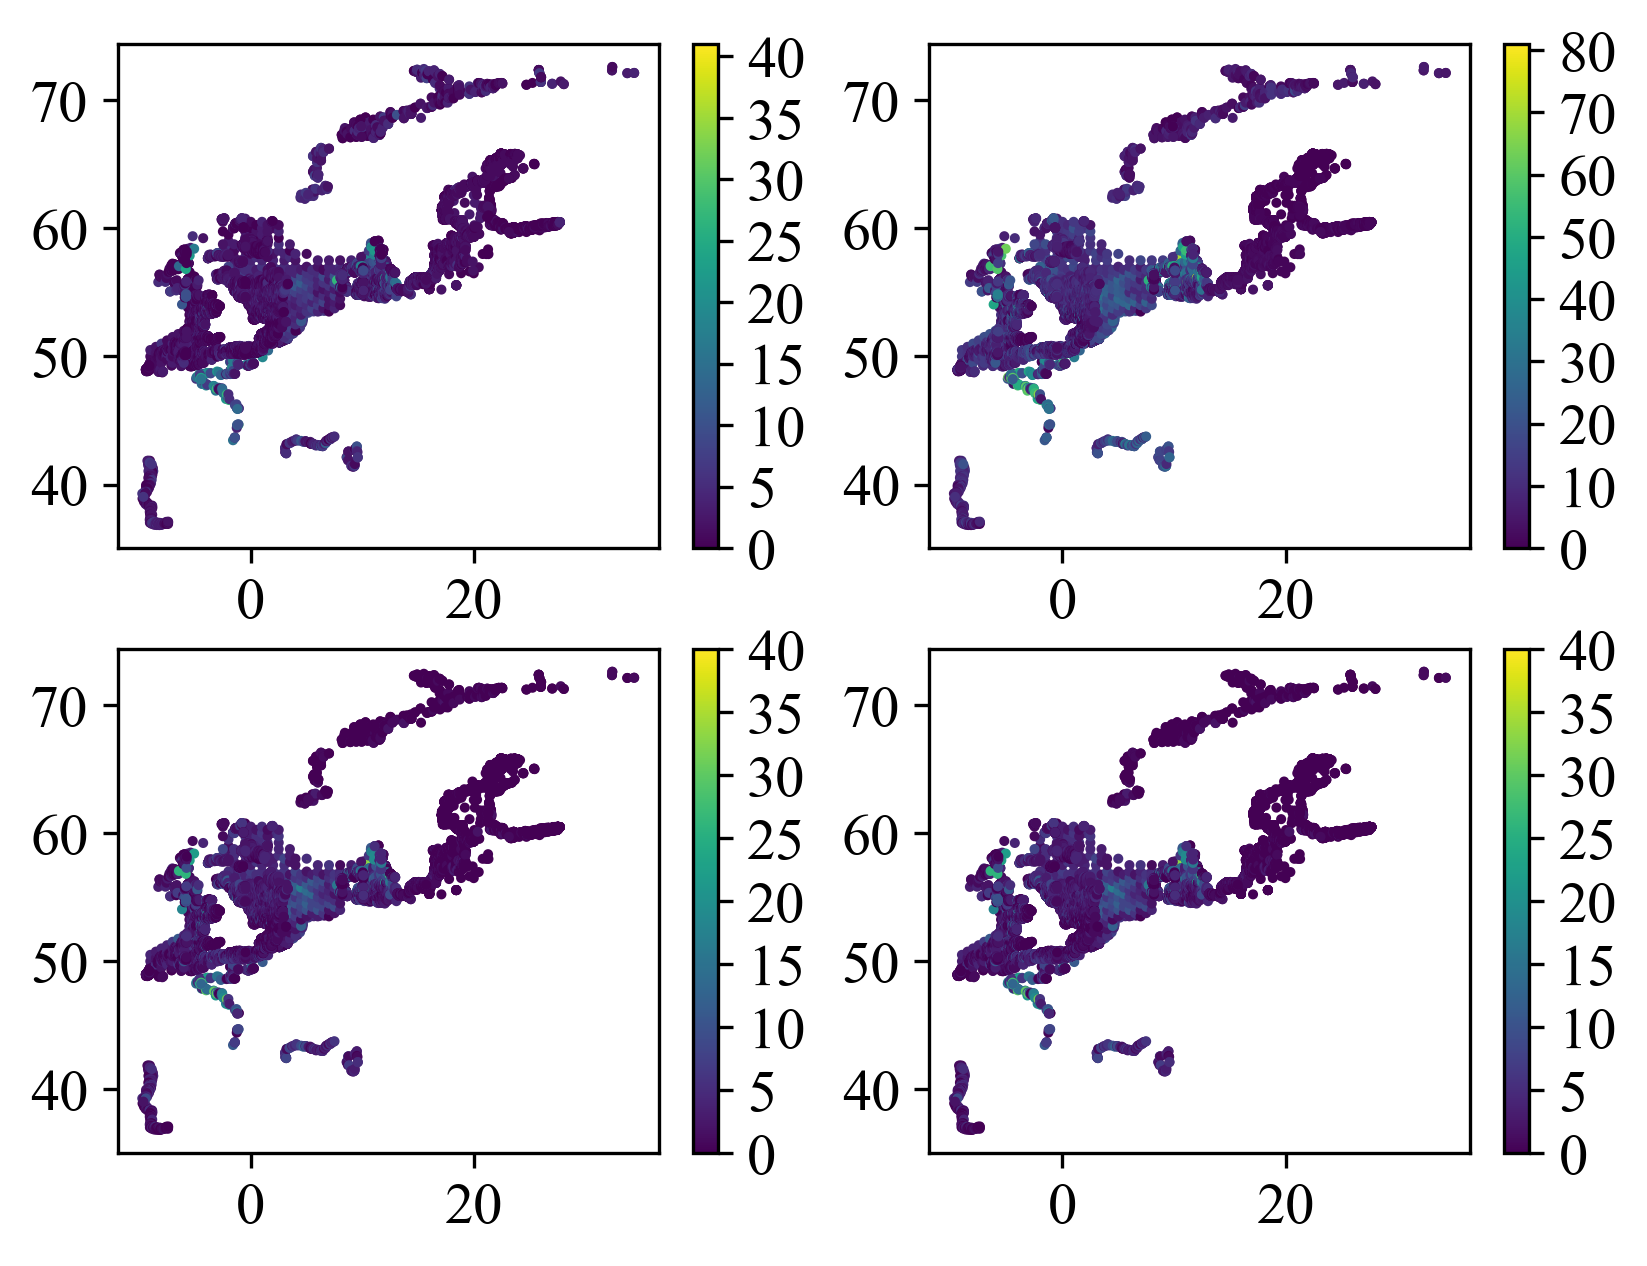

PyObject <matplotlib.colorbar.Colorbar object at 0x7f839f5e65f8>

In [184]:
figure()
subplot(2,2,1)
PyPlot.scatter(obslon, obslat, s=2, c=g1)
colorbar()
subplot(2,2,2)
PyPlot.scatter(obslon, obslat, s=2, c=g2)
colorbar()
subplot(2,2,3)
PyPlot.scatter(obslon, obslat, s=2, c=g3)
colorbar()
subplot(2,2,4)
PyPlot.scatter(obslon, obslat, s=2, c=g4)
colorbar()

In [37]:
save(filename,xyi,fi,varname

```
save(filename,xyi,fi,varname;
                      ncvarattrib = Dict(), ncglobalattrib = Dict(), ...)
```

Save the result of the analysis in a NetCDF file .

# Input arguments

  * `filename`: the name of the NetCDF file
  * `xyi`: tuple with n vectors. Every element in this tuple represents a coordinate of the final grid on which the observations are interpolated
  * `fi`: the analysed field
  * `varname`: the name of the NetCDF variable

# Optional arguments:

  * `ncglobalattrib`: a dictionary with the global attributes
  * `ncvarattrib`: a dictionary with the variable attributes
  * `relerr`: relative error
